# Orbit and stream simulation

# 1. Orbit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units
from astropy.io import ascii
import corner
from plot_functions import *
plt.rcParams.update(params)

from galpy.orbit import Orbit
from galpy import potential
from galpy.util import conversion
from galpy.potential import MWPotential2014, ChandrasekharDynamicalFrictionForce, HernquistPotential, \
                            MovingObjectPotential, evaluateRforces, evaluatephitorques, evaluatezforces, \
                            NonInertialFrameForce
from galpy.df import streamspraydf

Defining orbits, note the default parameters:
- Solar radius R = 8 kpc
- Circular velocity V = 220 km/s
- Solar motion [Schoenrich 2010](http://adsabs.harvard.edu/abs/2010MNRAS.403.1829S)

In [2]:
styx_trace = ascii.read('styx.trace')

data_wlmc = ascii.read('dwarf_stream_bootes_3_wLMC.txt')
data_wolmc = ascii.read('dwarf_stream_bootes_3_woLMC.txt')

# These are the same as the rv_mean, feh_mean, ... that are in Part 1 and 3
RA_BOO3 = 209.3     # deg
DEC_BOO3 = 26.8     # deg
DIST_BOO3 = 46.5    # kpc
PMRA_BOO3 = -1.16   # mas yr^-1
PMDEC_BOO3 = -0.88  # mas yr^-1
VEL_BOO3 = 189.11   # km s^-1

# Uncertainties of the above
U_DIST_BOO3 = 2.0   
U_PMRA_BOO3 = 0.02  
U_PMDEC_BOO3 = 0.01 
U_VEL_BOO3 = 1.56   
# no uncertainty info for position

## Setting up a total potential to be MWPotential2014 + LMC

In [3]:
def get_total_potential(forward=False):
    """Return a potential that includes MWPotential2014 and 
    the effects of LMC (a non-inertial force on the MW and 
    a LMC moving potential).
    
    The potential created by default is only valid for backward
    integration. If forward is True, the potential will be valid
    for forward integration.
    """
    # Define the LMC orbit object
    orbit_LMC = Orbit.from_name('LMC')

    # Define dynamical friction force
    cdf = ChandrasekharDynamicalFrictionForce(GMs=10.**11.*units.Msun, rhm=5.*units.kpc, dens=MWPotential2014)

    # Integrate the LMC orbit with the dynamical friction
    if forward:
        orbit_LMC.integrate(ts, MWPotential2014 + cdf)
    else:
        orbit_LMC.integrate(-ts, MWPotential2014 + cdf)
        
    # Set it as moving object potential
    lmcpot = HernquistPotential(amp=2*10.**11.*units.Msun, a=5.*units.kpc/(1.+np.sqrt(2.)))
    moving_lmcpot = MovingObjectPotential(orbit_LMC, pot=lmcpot)

    # Acceleration at origin
    loc_origin= 1e-4 # Small offset in R to avoid numerical issues
    ax = lambda t : evaluateRforces(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False)
    ay = lambda t : evaluatephitorques(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False) / loc_origin
    az = lambda t : evaluatezforces(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False)

    # Use interpolation function to speed things up
    if forward:
        t_intunits= orbit_LMC.time(use_physical=False)
    else:
        t_intunits= orbit_LMC.time(use_physical=False)[::-1]

    ax4int = np.array([ax(t) for t in t_intunits])
    ax_int = lambda t : np.interp(t, t_intunits, ax4int)
    ay4int = np.array([ay(t) for t in t_intunits])
    ay_int = lambda t : np.interp(t, t_intunits, ay4int)
    az4int = np.array([az(t) for t in t_intunits])
    az_int = lambda t : np.interp(t, t_intunits, az4int)

    nip = NonInertialFrameForce(a0=[ax_int, ay_int, az_int])

    return MWPotential2014 + nip + moving_lmcpot

## Orbit integration main code

**Note**: I am using vo = 233 here. Check [Equation (3) of this article](https://iopscience.iop.org/article/10.3847/2515-5172/aaef8b). It will look a bit different compared to the plots made in the orbit tutorial because those models were using vo = 220 (which is currently the galpy default).

In [4]:
# 6D parameters about the target galaxy
boo3_6D = [RA_BOO3, DEC_BOO3, DIST_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3]

# Make 1000 of them, treating uncertainty as Gaussian distribution
unc_list = [0, 0, U_DIST_BOO3, U_PMRA_BOO3, U_PMDEC_BOO3, U_VEL_BOO3]

boo3_6D_unc = np.random.normal(loc=boo3_6D, scale=unc_list, size=(1000, 6))

In [5]:
# Integration time scales (do not change, keep consistency)

# 5 Gyr
ts = np.linspace(0, 5, 1001)*units.Gyr

# 10 Gyr
ts2 = np.linspace(0., 10., 1001)*units.Gyr

## orbit1 : Integrate with just MW potential

Here's the explicit initialization of orbit
```python 
Orbit(boo3_6D, ro=8, vo=233, solarmotion=[-11.1, 12.24, 7.25], radec=True)
```

In [6]:
# Forward
orbit1_f = Orbit(boo3_6D, vo=233, radec=True)
orbit1_f.integrate(ts, MWPotential2014)

# Backward
orbit1_b = Orbit(boo3_6D, vo=233, radec=True)
orbit1_b.integrate(-ts, MWPotential2014)

In [7]:
# Uncertainties: 1000 times drawing from a Gaussian distribution

# Forward
orbit1_f_unc = Orbit(boo3_6D_unc, vo=233, radec=True)
orbit1_f_unc.integrate(ts, MWPotential2014)

# Backward
orbit1_b_unc = Orbit(boo3_6D_unc, vo=233, radec=True)
orbit1_b_unc.integrate(-ts, MWPotential2014)

## orbit2 : Integrate with MW potential plus LMC

In [8]:
potential_backward = get_total_potential()
potential_forward = get_total_potential(forward=True)

In [9]:
# Forward
orbit2_f = Orbit(boo3_6D, vo=233., radec=True)
orbit2_f.integrate(ts, potential_forward)

# Backward
orbit2_b = Orbit(boo3_6D, vo=233., radec=True)
orbit2_b.integrate(-ts, potential_backward)

In [10]:
# Uncertainties: 1000 times drawing from a Gaussian distribution

# Forward
orbit2_f_unc = Orbit(boo3_6D_unc, vo=233., radec=True)
orbit2_f_unc.integrate(ts, potential_forward)

# Backward
orbit2_b_unc = Orbit(boo3_6D_unc, vo=233., radec=True)
orbit2_b_unc.integrate(-ts, potential_backward)

## Plot

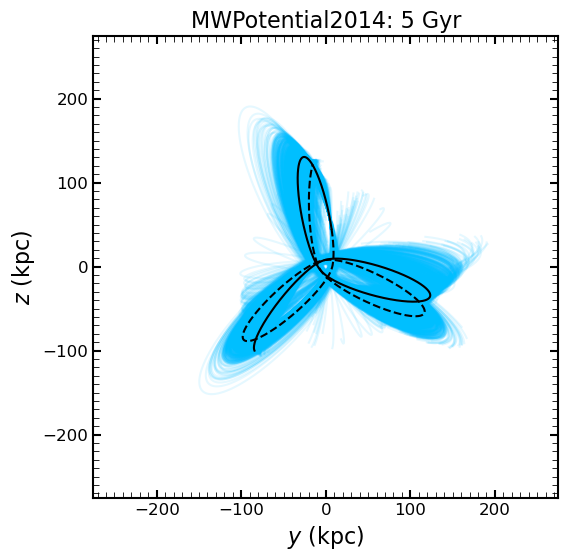

In [11]:
orbit1_b_unc.plot(d1='y', d2='z', c='deepskyblue', alpha=0.1)
orbit1_f_unc.plot(d1='y', d2='z', c='deepskyblue', alpha=0.1, overplot=True)
orbit1_b.plot(d1='y', d2='z', c='k', ls='--', overplot=True)
orbit1_f.plot(d1='y', d2='z', c='k', overplot=True)

ax = plt.gca()
ax.set_xlim(-275, 275)
ax.set_ylim(-275, 275)
ax.set_title('MWPotential2014: 5 Gyr')

fig = plt.gcf()
fig.set_size_inches(6, 6)

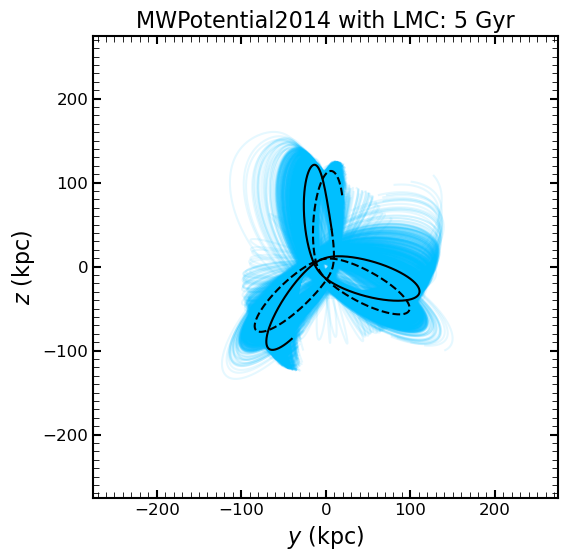

In [14]:
orbit2_b_unc.plot(d1='y', d2='z', c='deepskyblue', alpha=0.1)
orbit2_f_unc.plot(d1='y', d2='z', c='deepskyblue', alpha=0.1, overplot=True)
orbit2_b.plot(d1='y', d2='z', c='k', ls='--', overplot=True)
orbit2_f.plot(d1='y', d2='z', c='k', overplot=True)

ax = plt.gca()
ax.set_xlim(-275, 275)
ax.set_ylim(-275, 275)
ax.set_title('MWPotential2014 with LMC: 5 Gyr')

fig = plt.gcf()
fig.set_size_inches(6, 6)

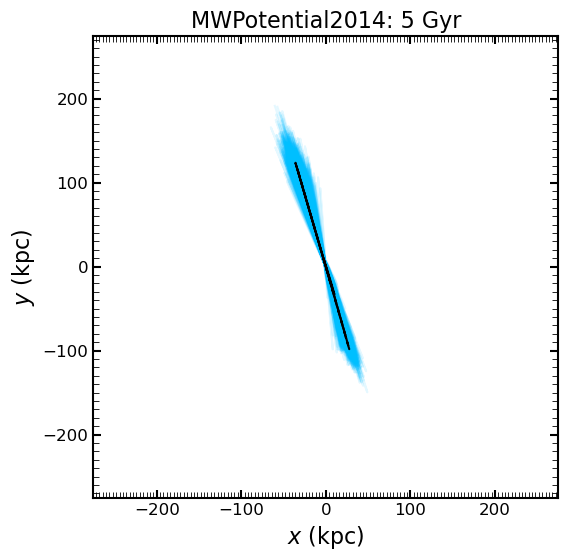

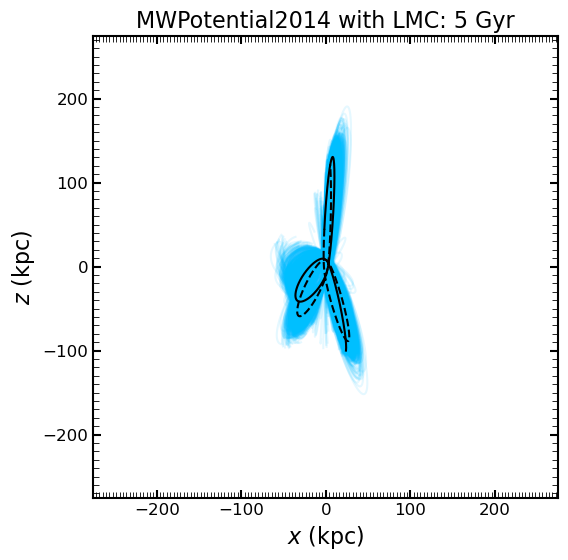

In [17]:
orbit1_b_unc.plot(d1='x', d2='y', c='deepskyblue', alpha=0.1)
orbit1_f_unc.plot(d1='x', d2='y', c='deepskyblue', alpha=0.1, overplot=True)
orbit1_b.plot(d1='x', d2='y', c='k', ls='--', overplot=True)
orbit1_f.plot(d1='x', d2='y', c='k', overplot=True)

ax = plt.gca()
ax.set_xlim(-275, 275)
ax.set_ylim(-275, 275)
ax.set_title('MWPotential2014: 5 Gyr')

fig = plt.gcf()
fig.set_size_inches(6, 6)


orbit1_b_unc.plot(d1='x', d2='z', c='deepskyblue', alpha=0.1)
orbit1_f_unc.plot(d1='x', d2='z', c='deepskyblue', alpha=0.1, overplot=True)
orbit1_b.plot(d1='x', d2='z', c='k', ls='--', overplot=True)
orbit1_f.plot(d1='x', d2='z', c='k', overplot=True)

ax = plt.gca()
ax.set_xlim(-275, 275)
ax.set_ylim(-275, 275)
ax.set_title('MWPotential2014 with LMC: 5 Gyr')

fig = plt.gcf()
fig.set_size_inches(6, 6)

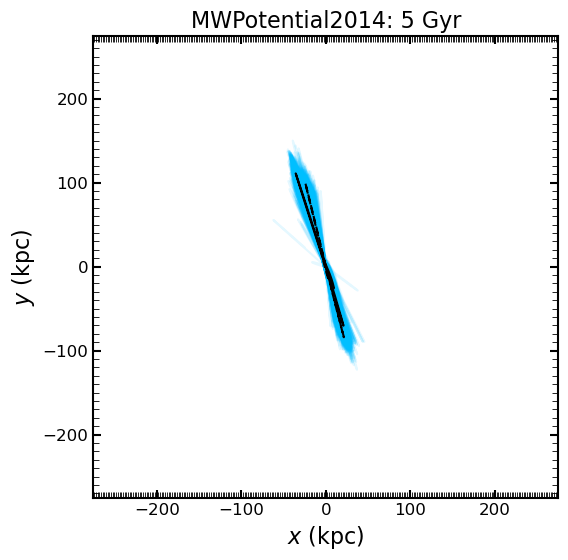

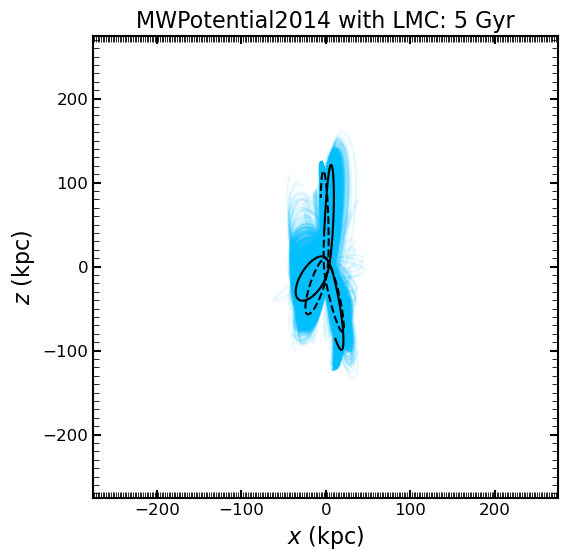

In [18]:
orbit2_b_unc.plot(d1='x', d2='y', c='deepskyblue', alpha=0.1)
orbit2_f_unc.plot(d1='x', d2='y', c='deepskyblue', alpha=0.1, overplot=True)
orbit2_b.plot(d1='x', d2='y', c='k', ls='--', overplot=True)
orbit2_f.plot(d1='x', d2='y', c='k', overplot=True)

ax = plt.gca()

ax.set_xlim(-275, 275)
ax.set_ylim(-275, 275)
ax.set_title('MWPotential2014: 5 Gyr')

fig = plt.gcf()
fig.set_size_inches(6, 6)

orbit2_b_unc.plot(d1='x', d2='z', c='deepskyblue', alpha=0.1)
orbit2_f_unc.plot(d1='x', d2='z', c='deepskyblue', alpha=0.1, overplot=True)
orbit2_b.plot(d1='x', d2='z', c='k', ls='--', overplot=True)
orbit2_f.plot(d1='x', d2='z', c='k', overplot=True)

ax = plt.gca()

ax.set_xlim(-275, 275)
ax.set_ylim(-275, 275)
ax.set_title('MWPotential2014 with LMC: 5 Gyr')

fig = plt.gcf()
fig.set_size_inches(6, 6)

## Orbital properties

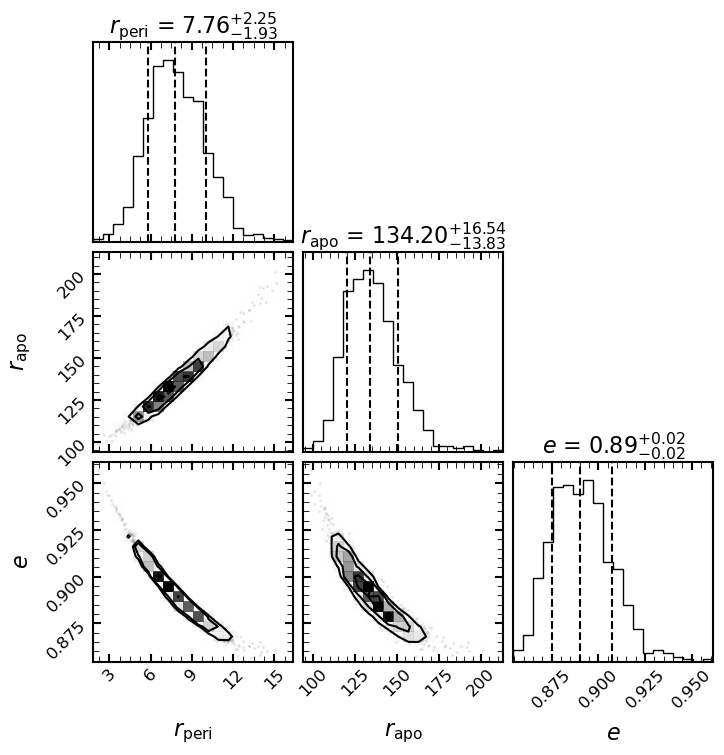

In [20]:
figure = corner.corner(np.vstack((orbit1_b_unc.rperi(), orbit1_b_unc.rap(), orbit1_b_unc.e())).T,
                       labels=['$r_\mathrm{peri}$', '$r_\mathrm{apo}$', '$e$'],
                       quantiles=[0.16, 0.50, 0.84],
                       show_titles=True,
                       ls='--', c='gray')
plt.show()

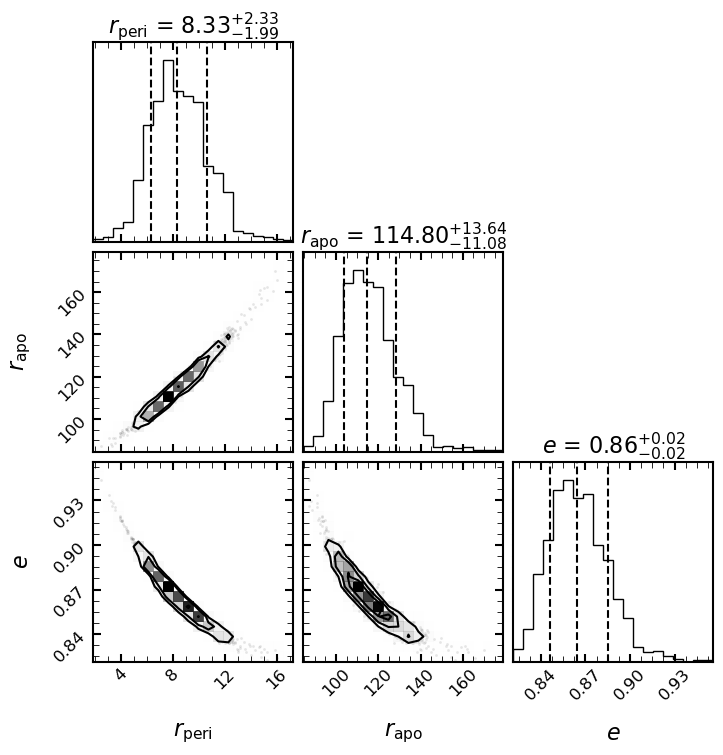

In [21]:
figure = corner.corner(np.vstack((orbit2_b_unc.rperi(), orbit2_b_unc.rap(), orbit2_b_unc.e())).T,
                       labels=['$r_\mathrm{peri}$', '$r_\mathrm{apo}$', '$e$'],
                       quantiles=[0.16, 0.50, 0.84],
                       show_titles=True,
                       ls='--', c='gray')
plt.show()

# 2. Stream

Compare the stream simulation with 5 different setups
1. Default
2. Default with LMC mass x2
3. Default with LMC rhm x2
4. Default with MW halo mass x2
5. Default with vo: 12 --> 24

By "default", we mean particularly that `vo` = 220

In [72]:
def get_potential_customize(mass_factor=1, rhm_factor=1, halo_mass_factor=1, update_vo=False, forward=False):
    """Same as get_total_potential(), with three additional options:
    1. Increase the LMC mass by mass_factor
    2. Increase rhm (half mass radius) by rhm_factor
    3. Increase MWPotential2014 mass by halo_mass_factor
    4. Use vo = 233 instead of vo = 220
    
    Default values are 1, which means there are no increases.
    """
    lmc_mass = 10.**11.*units.Msun * mass_factor
    lmc_rhm = 5.*units.kpc * rhm_factor
    halo_mass = MWPotential2014.copy()
    
    # I will only edit this potential object when really necessary
    if halo_mass_factor != 1:
        halo_mass[2] *= halo_mass_factor

    # Define the LMC orbit object    
    if update_vo:
        orbit_LMC = Orbit.from_name('LMC', vo=233)
    else:
        orbit_LMC = Orbit.from_name('LMC')

    # Define dynamical friction force
    cdf = ChandrasekharDynamicalFrictionForce(GMs=lmc_mass, rhm=lmc_rhm, dens=halo_mass)

    # Integrate the LMC orbit with the dynamical friction
    if forward:
        orbit_LMC.integrate(ts, halo_mass + cdf)
    else:
        orbit_LMC.integrate(-ts, halo_mass + cdf)
        
    # Set it as moving object potential
    lmcpot = HernquistPotential(amp=2*lmc_mass, a=lmc_rhm/(1+np.sqrt(2))) #rhm = (1+sqrt(2)) a
    moving_lmcpot = MovingObjectPotential(orbit_LMC, pot=lmcpot)

    # Acceleration at origin
    loc_origin= 1e-4 # Small offset in R to avoid numerical issues
    ax = lambda t : evaluateRforces(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False)
    ay = lambda t : evaluatephitorques(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False) / loc_origin
    az = lambda t : evaluatezforces(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False)

    # Use interpolation function to speed things up
    if forward:
        t_intunits= orbit_LMC.time(use_physical=False)
    else:
        t_intunits= orbit_LMC.time(use_physical=False)[::-1]

    ax4int = np.array([ax(t) for t in t_intunits])
    ax_int = lambda t : np.interp(t, t_intunits, ax4int)
    ay4int = np.array([ay(t) for t in t_intunits])
    ay_int = lambda t : np.interp(t, t_intunits, ay4int)
    az4int = np.array([az(t) for t in t_intunits])
    az_int = lambda t : np.interp(t, t_intunits, az4int)

    nip = NonInertialFrameForce(a0=[ax_int, ay_int, az_int])

    return halo_mass + nip + moving_lmcpot

In [23]:
tdisrupt = 3  # Gyr
mass = 1e7    # M_sun (mass of progenitor)

<div class='alert alert-block alert-success'>
    <h1 style="text-align:center;">1. Default</h1>
</div>

In [38]:
orbit_boo3 = Orbit(boo3_6D, radec=True)

In [24]:
potential1 = get_potential_customize()

In [34]:
# Leading arm
spdf1 = streamspraydf(progenitor_mass = mass*units.M_sun,
                      progenitor = orbit_boo3,
                      pot = potential1,
                      tdisrupt = tdisrupt*units.Gyr,
                      rtpot = MWPotential2014)

# Trailing arm
spdft1 = streamspraydf(progenitor_mass = mass*units.M_sun,
                       progenitor = orbit_boo3,
                       pot = potential1,
                       tdisrupt = tdisrupt*units.Gyr,
                       rtpot = MWPotential2014,
                       leading = False)

In [26]:
orbit_leading1 = spdf1.sample(n=200, integrate=True)
orbit_trailing1 = spdft1.sample(n=200, integrate=True)

<div class='alert alert-block alert-success'>
    <h1 style="text-align:center;">2. Default with LMC mass x2</h1>
</div>

In [39]:
potential2 = get_potential_customize(mass_factor=2)

In [44]:
# Only the SPDF change so let's not redefine all our other variables

# Leading arm
spdf2 = streamspraydf(progenitor_mass = mass*units.M_sun,
                     progenitor = orbit_boo3,
                     pot = potential2,
                     tdisrupt = tdisrupt*units.Gyr,
                     rtpot = MWPotential2014)

# Trailing arm
spdft2 = streamspraydf(progenitor_mass = mass*units.M_sun,
                      progenitor = orbit_boo3,
                      pot = potential2,
                      tdisrupt = tdisrupt*units.Gyr,
                      rtpot = MWPotential2014,
                      leading = False)

In [45]:
orbit_leading2 = spdf2.sample(n=200, integrate=True)
orbit_trailing2 = spdft2.sample(n=200, integrate=True)

<div class='alert alert-block alert-success'>
    <h1 style="text-align:center;">3. Default with LMC rhm x2</h1>
</div>

In [46]:
potential3 = get_potential_customize(rhm_factor=2)

In [47]:
# Only the SPDF change so let's not redefine all our other variables

# Leading arm
spdf3 = streamspraydf(progenitor_mass = mass*units.M_sun,
                     progenitor = orbit_boo3,
                     pot = potential3,
                     tdisrupt = tdisrupt*units.Gyr,
                     rtpot = MWPotential2014)

# Trailing arm
spdft3 = streamspraydf(progenitor_mass = mass*units.M_sun,
                      progenitor = orbit_boo3,
                      pot = potential3,
                      tdisrupt = tdisrupt*units.Gyr,
                      rtpot = MWPotential2014,
                      leading = False)

In [48]:
orbit_leading3 = spdf3.sample(n=200, integrate=True)
orbit_trailing3 = spdft3.sample(n=200, integrate=True)

<div class='alert alert-block alert-success'>
    <h1 style="text-align:center;">4. Default with MW halo mass x2</h1>
</div>

In [49]:
potential4 = get_potential_customize(halo_mass_factor=2)

In [50]:
MWpot14x2 = MWPotential2014.copy()
MWpot14x2[2] *= 2

In [51]:
# USE THE FIRST SET OF LMC VARIABLES

# Leading arm
spdf4 = streamspraydf(progenitor_mass = mass*units.M_sun,
                     progenitor = orbit_boo3,
                     pot = potential4,
                     tdisrupt = tdisrupt*units.Gyr,
                     rtpot = MWpot14x2)

# Trailing arm
spdft4 = streamspraydf(progenitor_mass = mass*units.M_sun,
                      progenitor = orbit_boo3,
                      pot = potential4,
                      tdisrupt = tdisrupt*units.Gyr,
                      rtpot = MWpot14x2,
                      leading = False)

In [52]:
orbit_leading4 = spdf4.sample(n=200, integrate=True)
orbit_trailing4 = spdft4.sample(n=200, integrate=True)

<div class='alert alert-block alert-success'>
    <h1 style="text-align:center;">5. Default with vo : 220 --> 233</h1>
</div>

In [73]:
orbit_boo3_new = Orbit(boo3_6D, vo=233, radec=True)
potential5 = get_potential_customize(update_vo=True)

In [74]:
# Leading arm
spdf5 = streamspraydf(progenitor_mass = mass*units.M_sun,
                     progenitor = orbit_boo3_new,
                     pot = potential5,
                     tdisrupt = tdisrupt*units.Gyr,
                     rtpot = MWPotential2014)

# Trailing arm
spdft5 = streamspraydf(progenitor_mass = mass*units.M_sun,
                      progenitor = orbit_boo3_new,
                      pot = potential5,
                      tdisrupt = tdisrupt*units.Gyr,
                      rtpot = MWPotential2014,
                      leading = False)

In [75]:
orbit_leading5 = spdf5.sample(n=200, integrate=True)
orbit_trailing5 = spdft5.sample(n=200, integrate=True)

In [68]:
# USE THE FIRST SET OF LMC VARIABLES

# Leading arm
spdf6 = streamspraydf(progenitor_mass = mass*units.M_sun,
                     progenitor = orbit_boo3,
                     pot = MWPotential2014,
                     tdisrupt = tdisrupt*units.Gyr)

# Trailing arm
spdft6 = streamspraydf(progenitor_mass = mass*units.M_sun,
                      progenitor = orbit_boo3,
                      pot = MWPotential2014,
                      tdisrupt = tdisrupt*units.Gyr,
                      leading = False)

In [69]:
orbit_leading6 = spdf6.sample(n=200, integrate=True)
orbit_trailing6 = spdft6.sample(n=200, integrate=True)

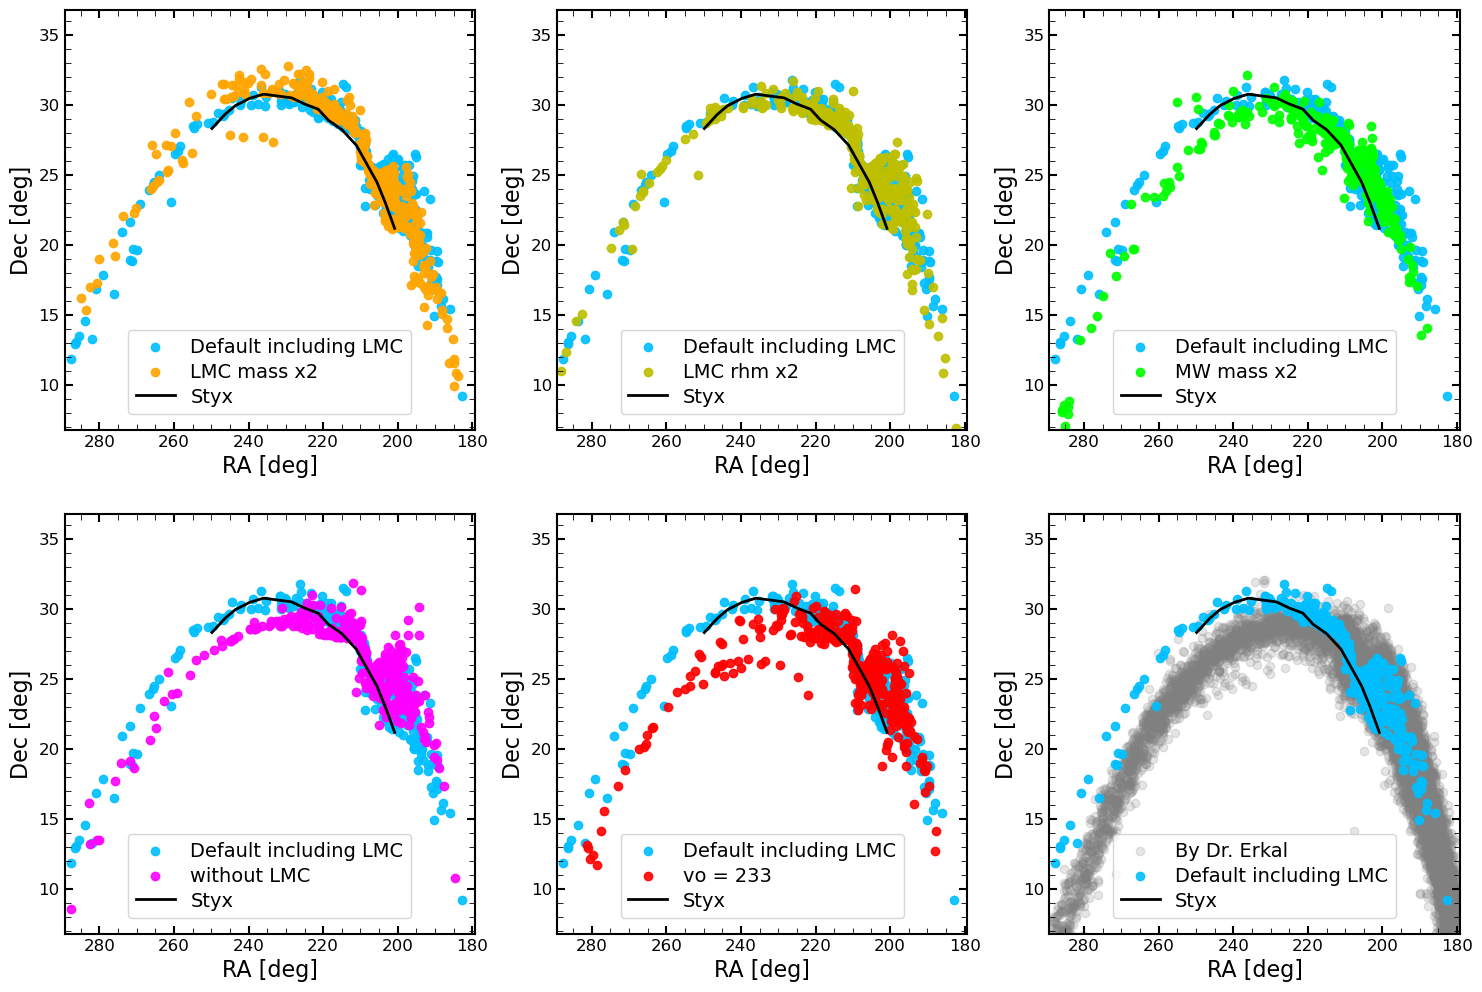

In [76]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12))

ax[0,0].scatter(np.append(orbit_leading1.ra(), orbit_trailing1.ra()), np.append(orbit_leading1.dec(), orbit_trailing1.dec()), c='deepskyblue', alpha=0.9, label='Default including LMC')
ax[0,0].scatter(np.append(orbit_leading2.ra(), orbit_trailing2.ra()), np.append(orbit_leading2.dec(), orbit_trailing2.dec()), c='orange', alpha=0.9, label='LMC mass x2')

ax[0,1].scatter(np.append(orbit_leading1.ra(), orbit_trailing1.ra()), np.append(orbit_leading1.dec(), orbit_trailing1.dec()), c='deepskyblue', alpha=0.9, label='Default including LMC')
ax[0,1].scatter(np.append(orbit_leading3.ra(), orbit_trailing3.ra()), np.append(orbit_leading3.dec(), orbit_trailing3.dec()), c='y', alpha=0.9, label='LMC rhm x2')

ax[0,2].scatter(np.append(orbit_leading1.ra(), orbit_trailing1.ra()), np.append(orbit_leading1.dec(), orbit_trailing1.dec()), c='deepskyblue', alpha=0.9, label='Default including LMC')
ax[0,2].scatter(np.append(orbit_leading4.ra(), orbit_trailing4.ra()), np.append(orbit_leading4.dec(), orbit_trailing4.dec()), c='lime', alpha=0.9, label='MW mass x2')

ax[1,0].scatter(np.append(orbit_leading1.ra(), orbit_trailing1.ra()), np.append(orbit_leading1.dec(), orbit_trailing1.dec()), c='deepskyblue', alpha=0.9, label='Default including LMC')
ax[1,0].scatter(np.append(orbit_leading6.ra(), orbit_trailing6.ra()), np.append(orbit_leading6.dec(), orbit_trailing6.dec()), c='magenta', alpha=0.9, label='without LMC')

ax[1,1].scatter(np.append(orbit_leading1.ra(), orbit_trailing1.ra()), np.append(orbit_leading1.dec(), orbit_trailing1.dec()), c='deepskyblue', alpha=0.9, label='Default including LMC')
ax[1,1].scatter(np.append(orbit_leading5.ra(), orbit_trailing5.ra()), np.append(orbit_leading5.dec(), orbit_trailing5.dec()), c='red', alpha=0.9, label='vo = 233')

ax[1,2].scatter(data_wlmc['ra']+360, data_wlmc['dec'], c='gray', alpha=0.2, label='By Dr. Erkal')
ax[1,2].scatter(np.append(orbit_leading1.ra(), orbit_trailing1.ra()), np.append(orbit_leading1.dec(), orbit_trailing1.dec()), c='deepskyblue', alpha=0.9, label='Default including LMC')

for i in range(2):
    for j in range(3):
        ax[i,j].plot(styx_trace['col1'], styx_trace['col2'], 'k', lw=2, label='Styx')
        ax[i,j].set_xlim(RA_BOO3-30, RA_BOO3+80)
        ax[i,j].set_ylim(DEC_BOO3-20, DEC_BOO3+10)
        ax[i,j].invert_xaxis()
        ax[i,j].set_xlabel('RA [deg]')
        ax[i,j].set_ylabel('Dec [deg]')
        ax[i,j].legend(loc='lower center')

#fig.legend(loc='center right', bbox_to_anchor=(1.15, 0.5))

plt.show()

### Just saving these data so that I can find them again

In [3]:
import pickle

In [87]:
fileObj = open('orbit_leading1.obj', 'wb')
pickle.dump(orbit_leading1, fileObj)
fileObj.close()

fileObj = open('orbit_trailing1.obj', 'wb')
pickle.dump(orbit_trailing1, fileObj)
fileObj.close()

fileObj = open('orbit_leading2.obj', 'wb')
pickle.dump(orbit_leading2, fileObj)
fileObj.close()

fileObj = open('orbit_trailing2.obj', 'wb')
pickle.dump(orbit_trailing2, fileObj)
fileObj.close()

fileObj = open('orbit_leading3.obj', 'wb')
pickle.dump(orbit_leading3, fileObj)
fileObj.close()

fileObj = open('orbit_trailing3.obj', 'wb')
pickle.dump(orbit_trailing3, fileObj)
fileObj.close()

fileObj = open('orbit_leading4.obj', 'wb')
pickle.dump(orbit_leading4, fileObj)
fileObj.close()

fileObj = open('orbit_trailing4.obj', 'wb')
pickle.dump(orbit_trailing4, fileObj)
fileObj.close()

fileObj = open('orbit_leading5.obj', 'wb')
pickle.dump(orbit_leading5, fileObj)
fileObj.close()

fileObj = open('orbit_trailing5.obj', 'wb')
pickle.dump(orbit_trailing5, fileObj)
fileObj.close()

fileObj = open('orbit_leading6.obj', 'wb')
pickle.dump(orbit_leading6, fileObj)
fileObj.close()

fileObj = open('orbit_trailing6.obj', 'wb')
pickle.dump(orbit_trailing6, fileObj)
fileObj.close()

In [4]:
fileObj = open('orbit_leading1.obj', 'rb')
orbit_leading1 = pickle.load(fileObj)
fileObj.close()

fileObj = open('orbit_trailing1.obj', 'rb')
orbit_trailing1 = pickle.load(fileObj)
fileObj.close()

fileObj = open('orbit_leading2.obj', 'rb')
orbit_leading2 = pickle.load(fileObj)
fileObj.close()

fileObj = open('orbit_trailing2.obj', 'rb')
orbit_trailing2 = pickle.load(fileObj)
fileObj.close()

fileObj = open('orbit_leading3.obj', 'rb')
orbit_leading3 = pickle.load(fileObj)
fileObj.close()

fileObj = open('orbit_trailing3.obj', 'rb')
orbit_trailing3 = pickle.load(fileObj)
fileObj.close()

fileObj = open('orbit_leading4.obj', 'rb')
orbit_leading4 = pickle.load(fileObj)
fileObj.close()

fileObj = open('orbit_trailing4.obj', 'rb')
orbit_trailing4 = pickle.load(fileObj)
fileObj.close()

fileObj = open('orbit_leading5.obj', 'rb')
orbit_leading5 = pickle.load(fileObj)
fileObj.close()

fileObj = open('orbit_trailing5.obj', 'rb')
orbit_trailing5 = pickle.load(fileObj)
fileObj.close()

fileObj = open('orbit_leading6.obj', 'rb')
orbit_leading6 = pickle.load(fileObj)
fileObj.close()

fileObj = open('orbit_trailing6.obj', 'rb')
orbit_trailing6 = pickle.load(fileObj)
fileObj.close()

Use galpy default settings as Fiducial and compare with other ones,
one for no LMC one for with LMC

Compare effect of changing one parameter at a time
